In [34]:
##### import
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as stats
import statsmodels.api as sm

from xgboost import XGBClassifier

from sklearn.externals import joblib

from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.model_selection import GridSearchCV

from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, RandomForestClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeRegressor

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso

from sklearn.preprocessing import StandardScaler

from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error, accuracy_score, precision_score, recall_score, confusion_matrix, plot_confusion_matrix
from sklearn.inspection import permutation_importance

In [35]:
##### random seeds
random_state = 10


##### models: hyperparameters (parameters were optimized after two rounds of selection)
##### random forest
n_estimators = [300] #[100, 200, 300, 400, 500, ,750, 1000]
max_depth = [None] #[None, 2, 4, 5]
max_features = ['auto'] #['auto', 2]
min_samples_leaf = [1] #[1, 2, 3]
oob_score = [True]
param_grid_rf = {'n_estimators': n_estimators,
                 'max_depth': max_depth,
                 'max_features': max_features,
                 'min_samples_leaf': min_samples_leaf,
                 'oob_score': oob_score}

##### gradient boosting classifier
n_estimators = [4500] #[100, 200, 500, 1000, 1500, 2000, 2500, 3000, 3500, 4000, 4250, 4500, 4750]
learning_rate = [0.05] #[0.1, 0.075, 0.05, 0.025, 0.01]
max_depth = [5] #[2, 5, 7, 10]
subsample = [0.15] #[0.1, 0.15, 0.2]
max_features = ['auto'] #['auto', 2, 3]
param_grid_gbr = {'n_estimators': n_estimators,
                  'learning_rate': learning_rate,
                  'max_depth': max_depth,
                  'max_features': max_features,
                  'subsample': subsample}

##### extreme gradient boosting (XGB) classifier
n_estimators = [3500] #[100, 200, 500, 1000, 1500, 2000, 2500, 3000, 3500, 4000]
learning_rate = [0.1] #[0.1, 0.075, 0.05, 0.01, 0.001]
gamma = [0.5] #[0.4, 0.5, 0.6]
subsample = [0.9] #[0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
min_child_weight = [1] #[1, 5, 10]
colsample_bytree = [0.9] #[0.6, 0.7, 0.8, 0.9, 1.0]
max_depth = [7] #[3, 4, 5, 6, 7, 8]
param_xgb = {'n_estimators': n_estimators, #[100, 200, 500, 1000, 1500, 2000, 2500, 3000, 3500, 4000]
          'learning_rate': learning_rate, #[0.1, 0.075, 0.05, 0.01, 0.001]
          'gamma': gamma, #[0.4, 0.5, 0.6]
          'subsample': subsample, #[0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
          'min_child_weight': min_child_weight,#[1, 5, 10]
          'colsample_bytree': colsample_bytree, #[0.6, 0.7, 0.8, 0.9, 1.0]
          'max_depth': max_depth} #[3, 4, 5, 6, 7, 8]

In [36]:
def pricing(x):
    if x >= 0 and x < 500000:
        return 0
    elif x >= 500000 and x < 1000000:
        return 1
    else: ### x >= 1000000
        return 2

def grid_search_cv(estimator, param_grid, X_train, y_train):
    grid_search = GridSearchCV(estimator, param_grid, cv = 5, verbose = 2, n_jobs = -1)
    grid_search.fit(X_train, y_train)
    print('best parameters:', grid_search.best_params_)
    return grid_search.best_estimator_, grid_search.best_params_ # , grid_search.cv_results_

def evaluate(model, X_test, y_test):
    y_pred = model.predict(X_test)
    
    #mae = mean_absolute_error(y_test, y_pred)
    #mse = mean_squared_error(y_test, y_pred)
    #rmse = np.sqrt(mse)
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='macro')
    recall = recall_score(y_test, y_pred, average='macro')

    print('accuracy: {:0.6f}'.format(accuracy))
    print('precision: {:0.6f}'.format(precision))
    print('recall: {:0.6f}'.format(recall))
    #print('mse: {:0.6f}'.format(mse))
    #print('rmse: {:0.6f}'.format(rmse))
    #print('r2: {:0.6f}'.format(r2))
    return accuracy, y_pred, precision, recall


def classify_model(model, param_grid, X_train, X_test, y_train, y_test):
    best_grid = grid_search_cv(model, param_grid, X_train, y_train)
    print(best_grid[0])
    
    ##### evaluate the optimal model
    print('Train dataset:')
    train_result = evaluate(best_grid[0], X_train, y_train)
    print('Test dataset:')
    test_result = evaluate(best_grid[0], X_test, y_test)
    return best_grid, train_result, test_result

In [37]:
##### dataset
modified = pd.read_csv("../data/modified_data.csv")
modified.head()

,image_id,street,city,city_code,bed,bath,sqft,price
0,0,1317 Van Buren Avenue,"Salton City, CA",317,3,2.0,1560,201900
1,1,124 C Street W,"Brawley, CA",48,3,2.0,713,228500
2,2,2304 Clark Road,"Imperial, CA",152,3,1.0,800,273950
3,3,755 Brawley Avenue,"Brawley, CA",48,3,1.0,1082,350000
4,4,2207 R Carrillo Court,"Calexico, CA",55,4,3.0,2547,385100


In [38]:
##### copy dataset
data = modified.copy()

In [39]:
##### set price range
data['price_range'] = data['price'].apply(pricing)

In [40]:
data

,image_id,street,city,city_code,bed,bath,sqft,price,price_range
0,0,1317 Van Buren Avenue,"Salton City, CA",317,3,2.0,1560,201900,0
1,1,124 C Street W,"Brawley, CA",48,3,2.0,713,228500,0
2,2,2304 Clark Road,"Imperial, CA",152,3,1.0,800,273950,0
3,3,755 Brawley Avenue,"Brawley, CA",48,3,1.0,1082,350000,0
4,4,2207 R Carrillo Court,"Calexico, CA",55,4,3.0,2547,385100,0
...,...,...,...,...,...,...,...,...,...
15469,15469,4156 Sterlingview Drive,"Moorpark, CA",227,5,4.1,4092,949000,1
15470,15470,4355 Avenida Prado,"Thousand Oaks, CA",372,5,3.0,2773,949900,1
15471,15471,12717 Koenigstein Rd Road,"Santa Paula, CA",338,3,2.0,1576,920000,1
15472,15472,36 Kunkle Street,"Oak View, CA",253,4,2.0,2086,997000,1


In [41]:
##### independent variables and dependent variable
X=data.drop(['image_id', 'street', 'city', 'price', 'price_range'], axis=1)
y=data['price_range']
y=np.array(y)

In [42]:
##### split data into training and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = random_state)
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(10831, 4)
(4643, 4)
(10831,)
(4643,)


In [43]:
##### models
model_rf, train_result_rf, test_result_rf = classify_model(RandomForestClassifier(random_state=random_state, verbose=1), param_grid_rf, X_train, X_test,  y_train, y_test)
model_gbr, train_result_gbr, test_result_gbr = classify_model(GradientBoostingClassifier(random_state=random_state, verbose=1), param_grid_gbr, X_train, X_test, y_train, y_test)
model_xgb, train_result_xgb, test_result_xgb = classify_model(XGBClassifier(random_state=random_state, verbose=1), param_xgb, X_train, X_test, y_train, y_test)

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:   10.6s remaining:   15.9s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   10.6s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   10.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 300 out of 300 | elapsed:    4.3s finished


best parameters: {'max_depth': None, 'max_features': 'auto', 'min_samples_leaf': 1, 'n_estimators': 300, 'oob_score': True}
RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=300,
                       n_jobs=None, oob_score=True, random_state=10, verbose=1,
                       warm_start=False)
Train dataset:


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 300 out of 300 | elapsed:    0.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


accuracy: 0.998246
precision: 0.998544
recall: 0.998162
Test dataset:


[Parallel(n_jobs=1)]: Done 300 out of 300 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


accuracy: 0.779884
precision: 0.760217
recall: 0.711314
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:  2.6min remaining:  4.0min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  2.7min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  2.7min finished


      Iter       Train Loss      OOB Improve   Remaining Time 
         1        1542.3056         181.8299            2.19m
         2        1503.4553         161.9166            1.98m
         3        1492.1098         144.7188            1.91m
         4        1447.4104         137.8801            1.93m
         5        1414.7265         117.1919            1.93m
         6        1429.0359         110.5405            1.91m
         7        1391.5661          90.5182            1.87m
         8        1396.6944          84.2432            1.87m
         9        1348.5997          86.2843            1.86m
        10        1356.5061          79.6523            1.86m
        20        1249.5812          32.9722            1.79m
        30        1173.1902          26.2070            1.80m
        40        1123.2835          27.2894            1.78m
        50        1109.6675          17.4604            1.76m
        60        1058.2746          31.2079            1.74m
       

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:  2.1min remaining:  3.1min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  2.1min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  2.1min finished
C:\Users\wcjohnchen\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[19:43:52] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[19:43:52] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
best parameters: {'colsample_bytree': 0.9, 'gamma': 0.5, 'learning_rate': 0.1, 'max_depth': 7, 'min_child_weight': 1, 'n_estimators': 3500, 'subsample': 0.9}
XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.9, gamma=0.5, gpu_id=-

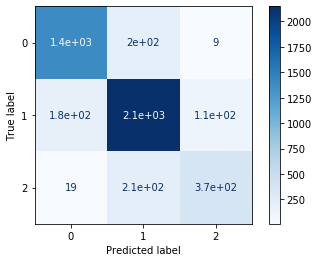

In [44]:
cm = confusion_matrix(y_test, test_result_gbr[1])
plot_confusion_matrix(model_gbr[0], X_test, y_test, cmap=plt.cm.Blues)  
plt.show()

In [45]:
#joblib.dump(model_gbr[0], 'gbr.ml')
joblib.dump(model_xgb[0], 'xgb.ml')

['xgb.ml']